In [1]:
from google.colab import files

print("Please upload consumer_complaints.csv, config.py, and utils.py:")
uploaded = files.upload()

for filename in uploaded.keys():
    print(f"Uploaded: {filename}")

Please upload consumer_complaints.csv, config.py, and utils.py:


Saving config.py to config.py
Saving utils.py to utils.py
Uploaded: config.py
Uploaded: utils.py


In [2]:
# Import the libraries

import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from transformers import (
    AutoTokenizer,
    TFAutoModelForSequenceClassification,
    create_optimizer,
)
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import config
from utils import save_object, load_object
import os

In [3]:
# Check for GPU Availability
if tf.config.list_physical_devices('GPU'):
    print("GPU is available for TensorFlow! Training will be faster.")
else:
    print("WARNING: GPU not found. Training might be slow on CPU.")

GPU is available for TensorFlow! Training will be faster.


In [4]:
# Data Loading and Initial Exploration
import csv

def load_and_explore_data(file_path: str, text_col: str, label_col: str):
    """Loads data, handles missing values, and performs initial exploration."""
    print(f"\nLoading data from {file_path}")
    if not os.path.exists(file_path):
        raise FileNotFoundError(f"Data file not found at: {file_path}")

    df = pd.read_csv(file_path, sep=None, engine='python', encoding='utf-8', on_bad_lines="skip", quotechar='"',
                 quoting=csv.QUOTE_ALL)

    print("\nInitial DataFrame Info:")
    df.info()

    # We first drop rows where the consumer_complaint_narrative is missing or where it's explicitly 'N/A'
    initial_rows = len(df)
    df.dropna(subset=[text_col], inplace=True)
    df = df[df[text_col].astype(str).str.strip() != '']
    df = df[df[text_col].astype(str).str.lower() != 'n/a']
    rows_after_dropna = len(df)
    print(f"\nDropped {initial_rows - rows_after_dropna} rows with missing or empty '{text_col}'.")

    # Basic data info - focus on relevant columns
    print(f"\nFirst 5 rows (relevant columns):")
    print(df[[text_col, label_col]].head())

    # Check label distribution
    print(f"\nLabel distribution for '{label_col}':")
    label_counts = df[label_col].value_counts()
    print(label_counts)
    print(f"Number of unique labels: {len(label_counts)}")

    if len(label_counts) < 2:
        raise ValueError("Dataset must have at least two unique labels for classification.")

    return df

df = load_and_explore_data(config.DATA_FILE_PATH, config.TEXT_COLUMN, config.LABEL_COLUMN)


Loading data from complaints.csv

Initial DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20181 entries, 0 to 20180
Data columns (total 18 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   date_received                 20181 non-null  object 
 1   product                       20181 non-null  object 
 2   sub_product                   20181 non-null  object 
 3   issue                         20181 non-null  object 
 4   sub_issue                     17483 non-null  object 
 5   consumer_complaint_narrative  20181 non-null  object 
 6   company_public_response       10911 non-null  object 
 7   company                       20180 non-null  object 
 8   state                         20063 non-null  object 
 9   zip_code                      15638 non-null  object 
 10  tags                          3436 non-null   object 
 11  consumer_consent_provided     20180 non-null  object 
 12  s

In [5]:
# Data Preprocessing
def preprocess_data(df: pd.DataFrame, text_col: str, label_col: str):
    """
    Encodes labels and performs minimal text cleaning.
    """
    print("\n--- Preprocessing Data ---")

    # Label Encoding
    label_encoder = LabelEncoder()
    labels_encoded = label_encoder.fit_transform(df[label_col])
    print(f"Encoded labels: {label_encoder.classes_}")

    # Save label encoder
    os.makedirs(os.path.dirname(config.LABEL_ENCODER_PATH), exist_ok=True)
    save_object(label_encoder, config.LABEL_ENCODER_PATH)

    # Text Preprocessing - Ensure text is string type and strip whitespace, then convert to list
    texts = df[text_col].astype(str).apply(lambda x: x.strip()).tolist()

    return texts, labels_encoded, label_encoder

texts, labels_encoded, label_encoder = preprocess_data(df, config.TEXT_COLUMN, config.LABEL_COLUMN)


--- Preprocessing Data ---
Encoded labels: ['Checking or savings account' 'Credit card or prepaid card'
 'Credit reporting, credit repair services, or other personal consumer reports'
 'Debt collection' 'Money transfer, virtual currency, or money service'
 'Mortgage' 'Payday loan, title loan, or personal loan' 'Student loan'
 'Vehicle loan or lease']
Object saved to ./models/label_encoder.pkl


In [6]:
num_labels = len(label_encoder.classes_)
print(f"Detected {num_labels} unique labels.")

Detected 9 unique labels.


In [7]:
# Data spliting

def split_data(texts: list, labels: np.ndarray):
    """
    Splits data into training, validation, and test sets
    """
    print("\nSplitting data...")
    X_train, X_temp, y_train, y_temp = train_test_split(texts, labels, test_size=config.TEST_SIZE,
                                                        random_state=config.RANDOM_SEED, stratify=labels)

    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5,
                                                   random_state=config.RANDOM_SEED, stratify=y_temp)

    print(f"Train samples: {len(X_train)} (Labels: {len(y_train)})")
    print(f"Validation samples: {len(X_val)} (Labels: {len(y_val)})")
    print(f"Test samples: {len(X_test)} (Labels: {len(y_test)})")

    # We verify if the data is well stratified - this is because the data is highly imbalanced
    print("\nTrain Label Distribution:")
    unique_train, counts_train = np.unique(y_train, return_counts=True)
    print(dict(zip(unique_train, counts_train)))

    print("\nValidation Label Distribution:")
    unique_val, counts_val = np.unique(y_val, return_counts=True)
    print(dict(zip(unique_val, counts_val)))

    print("\nTest Label Distribution:")
    unique_test, counts_test = np.unique(y_test, return_counts=True)
    print(dict(zip(unique_test, counts_test)))

    return X_train, X_val, X_test, y_train, y_val, y_test

X_train, X_val, X_test, y_train, y_val, y_test = split_data(texts, labels_encoded)


Splitting data...
Train samples: 16144 (Labels: 16144)
Validation samples: 2018 (Labels: 2018)
Test samples: 2019 (Labels: 2019)

Train Label Distribution:
{np.int64(0): np.int64(999), np.int64(1): np.int64(1638), np.int64(2): np.int64(7118), np.int64(3): np.int64(3412), np.int64(4): np.int64(357), np.int64(5): np.int64(1266), np.int64(6): np.int64(314), np.int64(7): np.int64(642), np.int64(8): np.int64(398)}

Validation Label Distribution:
{np.int64(0): np.int64(125), np.int64(1): np.int64(204), np.int64(2): np.int64(890), np.int64(3): np.int64(426), np.int64(4): np.int64(45), np.int64(5): np.int64(158), np.int64(6): np.int64(39), np.int64(7): np.int64(81), np.int64(8): np.int64(50)}

Test Label Distribution:
{np.int64(0): np.int64(125), np.int64(1): np.int64(205), np.int64(2): np.int64(890), np.int64(3): np.int64(427), np.int64(4): np.int64(44), np.int64(5): np.int64(159), np.int64(6): np.int64(39), np.int64(7): np.int64(80), np.int64(8): np.int64(50)}


In [8]:
# Tokenization

def tokenize_data(texts: list, tokenizer, max_len: int):
    """Tokenizes a list of texts using the provided tokenizer."""
    print(f"\n--- Tokenizing data with {config.MODEL_NAME} (max_length={max_len}) ---")
    encodings = tokenizer(
        texts,
        truncation=True,
        padding='max_length',
        max_length=max_len,
        return_tensors='tf'
    )
    print("Tokenization complete.")
    return encodings


tokenizer = AutoTokenizer.from_pretrained(config.MODEL_NAME)

train_encodings = tokenize_data(X_train, tokenizer, config.MAX_SEQUENCE_LENGTH)
val_encodings = tokenize_data(X_val, tokenizer, config.MAX_SEQUENCE_LENGTH)
test_encodings = tokenize_data(X_test, tokenizer, config.MAX_SEQUENCE_LENGTH)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]


--- Tokenizing data with distilbert-base-uncased (max_length=256) ---
Tokenization complete.

--- Tokenizing data with distilbert-base-uncased (max_length=256) ---
Tokenization complete.

--- Tokenizing data with distilbert-base-uncased (max_length=256) ---
Tokenization complete.


In [9]:
# Create TensorFlow Datasets
# Convert tokenized data and labels into optimized TensorFlow tf.data.Dataset objects
# Shuffle only the training data for better generalization

def create_tf_dataset(encodings, labels, batch_size, shuffle: bool = False):
    """Creates a tf.data.Dataset from encodings and labels."""
    dataset = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(labels)) # Shuffle the entire dataset
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset


train_dataset_tf = create_tf_dataset(train_encodings, y_train, config.BATCH_SIZE_TRAIN, shuffle=True)
val_dataset_tf = create_tf_dataset(val_encodings, y_val, config.BATCH_SIZE_EVAL, shuffle=False)
test_dataset_tf = create_tf_dataset(test_encodings, y_test, config.BATCH_SIZE_EVAL, shuffle=False)

In [10]:
# Model Training

def calculate_evaluation_metrics(y_true, y_pred_logits):
    """
    Computes various evaluation metrics from true labels and model logits.
    """
    predictions = np.argmax(y_pred_logits, axis=-1)

    # Calculate metrics
    accuracy = accuracy_score(y_true, predictions)
    f1 = f1_score(y_true, predictions, average='weighted') # Use weighted for multi-class
    precision = precision_score(y_true, predictions, average='weighted', zero_division=0)
    recall = recall_score(y_true, predictions, average='weighted', zero_division=0)

    return {
        "accuracy": accuracy,
        "f1": f1,
        "precision": precision,
        "recall": recall,
        "predictions_encoded": predictions # Return predictions for report/matrix
    }

In [11]:
def train_model(train_dataset_tf, val_dataset_tf, num_labels: int):
    """
    Initializes and trains the sequence classification model using Keras's
    model.compile() and model.fit() methods.
    """
    print(f"\nInitializing and Training Model ({config.MODEL_NAME})")

    # Load model for sequence classification with the correct number of labels
    model = TFAutoModelForSequenceClassification.from_pretrained(
        config.MODEL_NAME, num_labels=num_labels
    )

    # Define optimizer, loss, and metrics for Keras compile
    optimizer = tf.keras.optimizers.Adam(learning_rate=config.LEARNING_RATE)
    # Use SparseCategoricalCrossentropy as labels are integers (0, 1, 2, ...)
    # from_logits=True because the model outputs raw logits, not probabilities
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy')]

    # Compile the model
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    print("Starting training with model.fit()...")
    # Train the model using Keras's fit method
    history = model.fit(
        train_dataset_tf,
        epochs=config.NUM_TRAIN_EPOCHS,
        validation_data=val_dataset_tf
    )
    print("--- Model Training Complete ---")

    return model, history


model, history = train_model(train_dataset_tf, val_dataset_tf, num_labels)


Initializing and Training Model (distilbert-base-uncased)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Starting training with model.fit()...
Epoch 1/5
2018/2018 [==============================] - 492s 231ms/step - loss: 0.7341 - accuracy: 0.7637 - val_loss: 0.5576 - val_accuracy: 0.8137
Epoch 2/5
2018/2018 [==============================] - 467s 231ms/step - loss: 0.4840 - accuracy: 0.8461 - val_loss: 0.5269 - val_accuracy: 0.8186
Epoch 3/5
2018/2018 [==============================] - 468s 232ms/step - loss: 0.3501 - accuracy: 0.8899 - val_loss: 0.5291 - val_accuracy: 0.8266
Epoch 4/5
2018/2018 [==============================] - 466s 231ms/step - loss: 0.2511 - accuracy: 0.9222 - val_loss: 0.6177 - val_accuracy: 0.8231
Epoch 5/5
2018/2018 [==============================] - 467s 231ms/step - loss: 0.1747 - accuracy: 0.9489 - val_loss: 0.7011 - val_accuracy: 0.8325
--- Model Training Complete ---



Evaluating Model on Test Set
127/127 [==============================] - 20s 154ms/step - loss: 0.7416 - accuracy: 0.8172
Test Set Evaluation Results: Loss: 0.7416, Accuracy: 0.8172

Generating Predictions on Test Set
127/127 [==============================] - 21s 153ms/step

Classification Report
                                                                              precision    recall  f1-score   support

                                                 Checking or savings account       0.79      0.70      0.75       125
                                                 Credit card or prepaid card       0.77      0.80      0.79       205
Credit reporting, credit repair services, or other personal consumer reports       0.89      0.87      0.88       890
                                                             Debt collection       0.79      0.80      0.80       427
                          Money transfer, virtual currency, or money service       0.65      0.59      0.62   

<ipython-input-12-b53d932aa9bf>:41: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


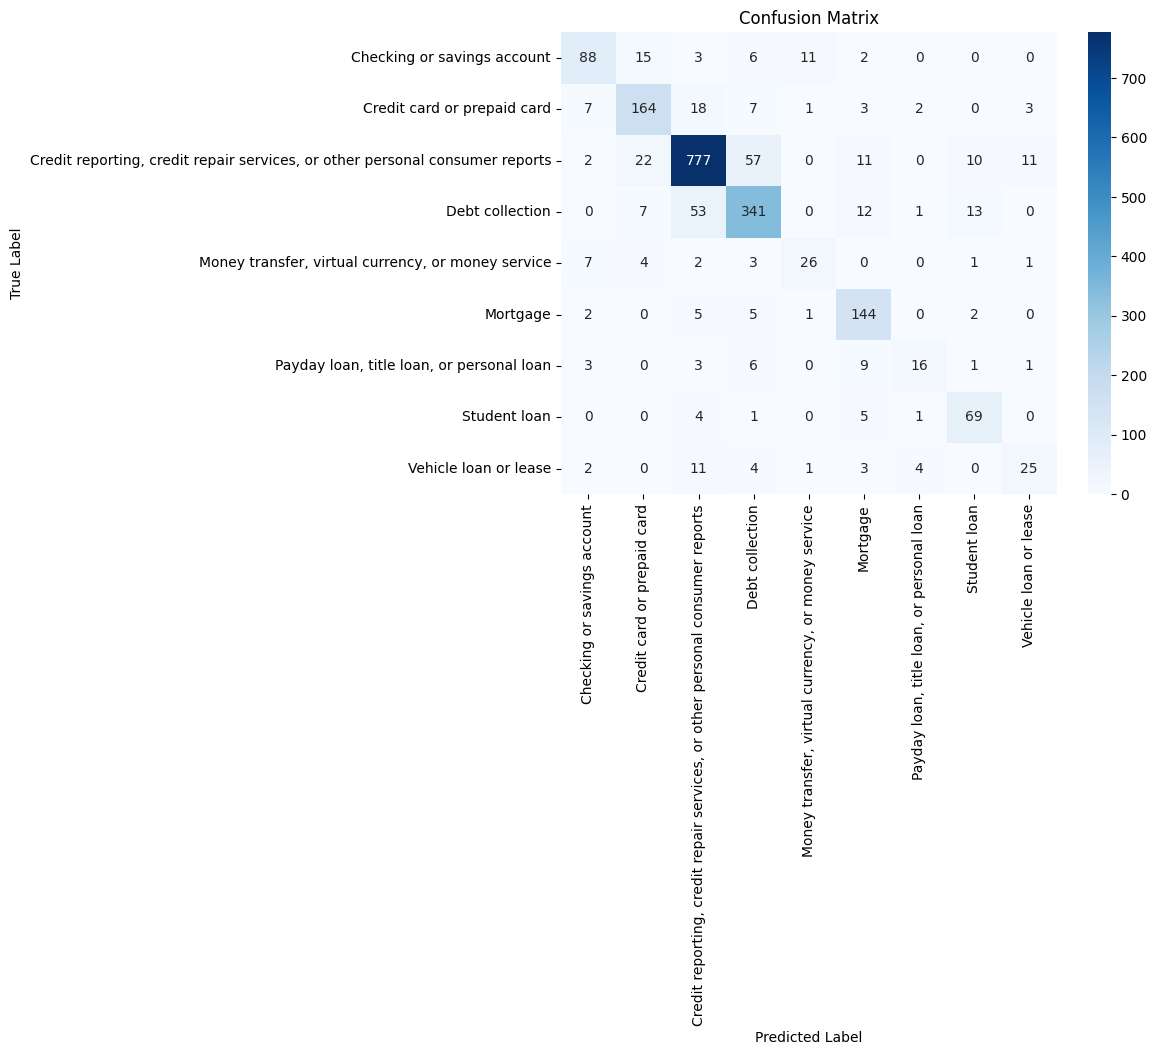

In [12]:
# Model Evaluation
def evaluate_model(model, test_dataset_tf, y_true: np.ndarray, label_encoder):
    """
    Evaluates the trained model and performs predictions on the test set.
    Generates and displays classification report and confusion matrix.
    """
    print("\nEvaluating Model on Test Set")
    loss, accuracy = model.evaluate(test_dataset_tf)
    print(f"Test Set Evaluation Results: Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    print("\nGenerating Predictions on Test Set")

    predictions_output = model.predict(test_dataset_tf)
    logits = predictions_output.logits if hasattr(predictions_output, 'logits') else predictions_output

    # Calculate detailed metrics using our custom function
    metrics_results = calculate_evaluation_metrics(y_true, logits)
    predicted_labels_encoded = metrics_results["predictions_encoded"]

    # Convert encoded labels back to original string labels for readability
    predicted_labels_decoded = label_encoder.inverse_transform(predicted_labels_encoded)
    true_labels_decoded = label_encoder.inverse_transform(y_true)

    print("\nClassification Report")
    # target_names are crucial for readability in the report
    print(classification_report(true_labels_decoded, predicted_labels_decoded,
                                target_names=label_encoder.classes_, zero_division=0))

    print("\nConfusion Matrix")
    cm = confusion_matrix(true_labels_decoded, predicted_labels_decoded,
                          labels=label_encoder.classes_)
    print(cm)

    # Visualize Confusion Matrix
    plt.figure(figsize=(max(8, len(label_encoder.classes_) * 0.8), max(6, len(label_encoder.classes_) * 0.6)))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.show()

    return predicted_labels_encoded, cm

predicted_labels_encoded, cm = evaluate_model(model, test_dataset_tf, y_test, label_encoder)

In [13]:
# Model Saving

print(f"\nSaving Model and Tokenizer to {config.TRAINED_MODEL_PATH}")
os.makedirs(config.TRAINED_MODEL_PATH, exist_ok=True) # Ensure directory exists
model.save_pretrained(config.TRAINED_MODEL_PATH)
tokenizer.save_pretrained(config.TRAINED_MODEL_PATH)
print("Model and Tokenizer saved.")


Saving Model and Tokenizer to ./models/complaints_classifier
Model and Tokenizer saved.


In [14]:
# Example of how the model can be used on new data

print("\nDemonstrating Model Inference")
try:
    # Load the saved model and tokenizer for making new predictions
    loaded_tokenizer = AutoTokenizer.from_pretrained(config.TRAINED_MODEL_PATH)
    loaded_model = TFAutoModelForSequenceClassification.from_pretrained(config.TRAINED_MODEL_PATH)
    loaded_label_encoder = load_object(config.LABEL_ENCODER_PATH)

    if loaded_model is not None and loaded_tokenizer is not None and loaded_label_encoder is not None:
        sample_complaints = [
            "My bank charged me an overdraft fee even though I had money in my account.",
            "I received multiple calls from a debt collector about a debt I already paid off.",
            "My credit report shows an account that I never opened, and it's hurting my score."
        ]

        print("\nSample Complaints for Inference:")
        for i, complaint in enumerate(sample_complaints):
            print(f"{i+1}. {complaint}")

        # Tokenize new input
        inference_encodings = loaded_tokenizer(
            sample_complaints,
            truncation=True,
            padding='max_length',
            max_length=config.MAX_SEQUENCE_LENGTH,
            return_tensors='tf'
        )

        # Make predictions
        tf_dataset_inference = tf.data.Dataset.from_tensor_slices(dict(inference_encodings)).batch(1)
        logits = loaded_model.predict(tf_dataset_inference).logits
        predictions_encoded = np.argmax(logits, axis=-1)

        # Decode predictions back to original product names
        predictions_decoded = loaded_label_encoder.inverse_transform(predictions_encoded)

        print("\nInference Results:")
        for complaint, prediction in zip(sample_complaints, predictions_decoded):
            print(f"Complaint: '{complaint}'\nPredicted Product: '{prediction}'\n")
    else:
        print("Could not load model, tokenizer, or label encoder for inference (one or more are None).")

except Exception as e:
    print(f"Error during inference demonstration: {e}")
    import traceback
    traceback.print_exc()

print("\n--- Project Finished ---")


Demonstrating Model Inference


Some layers from the model checkpoint at ./models/complaints_classifier were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at ./models/complaints_classifier and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Object loaded from ./models/label_encoder.pkl

Sample Complaints for Inference:
1. My bank charged me an overdraft fee even though I had money in my account.
2. I received multiple calls from a debt collector about a debt I already paid off.
3. My credit report shows an account that I never opened, and it's hurting my score.
3/3 [==============================] - 2s 32ms/step

Inference Results:
Complaint: 'My bank charged me an overdraft fee even though I had money in my account.'
Predicted Product: 'Checking or savings account'

Complaint: 'I received multiple calls from a debt collector about a debt I already paid off.'
Predicted Product: 'Debt collection'

Complaint: 'My credit report shows an account that I never opened, and it's hurting my score.'
Predicted Product: 'Credit reporting, credit repair services, or other personal consumer reports'


--- Project Finished ---
